In [1]:
# NN packages
import jax
import jax.numpy as jnp

# Visualization packages
import matplotlib.pyplot as plt

# Helper functions
from helpers import save_to_file, create_modal_training_data, plot_S_curves, plot_3DS_curves, plot_FRC

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **modal coordinates**.

In [2]:
filename='frequency_step_frequency_'
path='Conx/modal_freq'
start=10.0
stop=24.0
step=0.2

# filename='amplitude_step_amplitude_'
# path='Conx/modal_amp'
# start=0.1
# stop=2.0
# step=0.1

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

Data saved to Conx/modal_freq/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 301, 39), vel: (2, 301, 39), acc: (2, 301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (2, 301, 39)


In [3]:
train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Training data shape: (820969, 2, 4), Testing data shape: (211413, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (820969, 2), dx_train.shape: (820969, 2), ddx_train.shape: (820969, 2), force_train.shape: (820969, 2)
x_test.shape: (211413, 2), dx_test.shape: (211413, 2), ddx_test.shape: (211413, 2), force_test.shape: (211413, 2)


#### Dataset Visualization

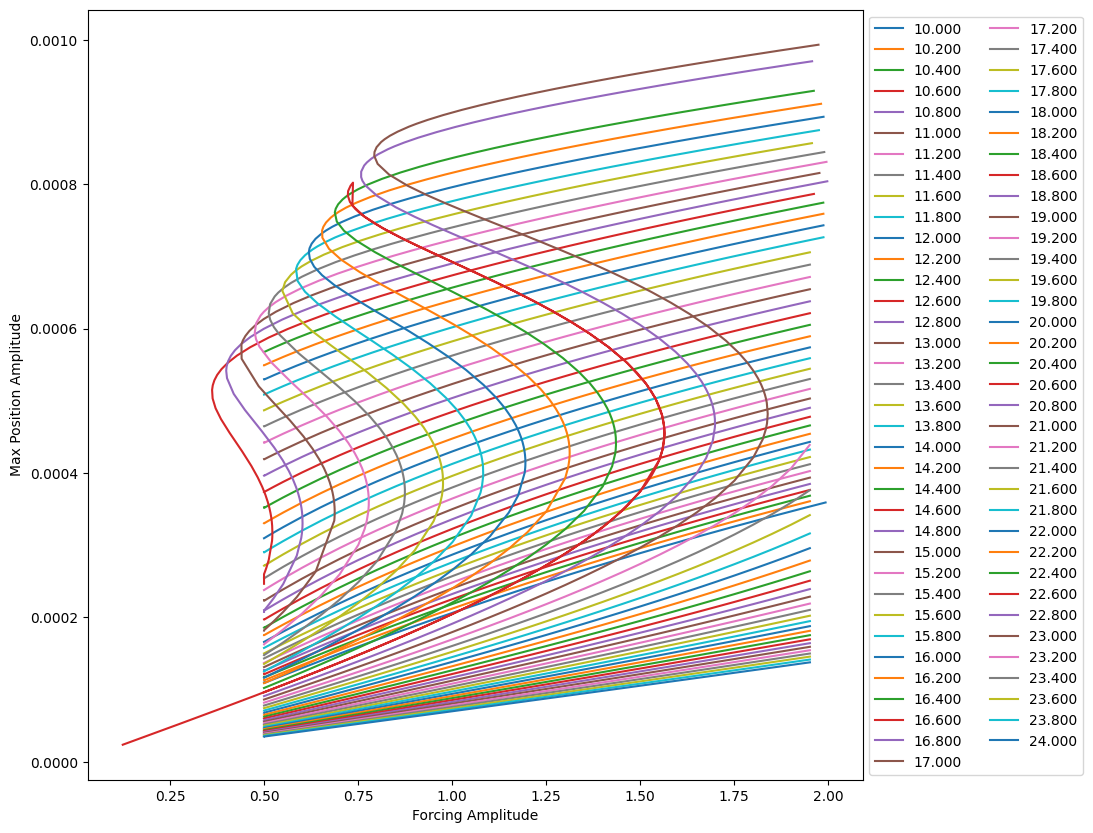

In [4]:
plot_S_curves(ml_data)

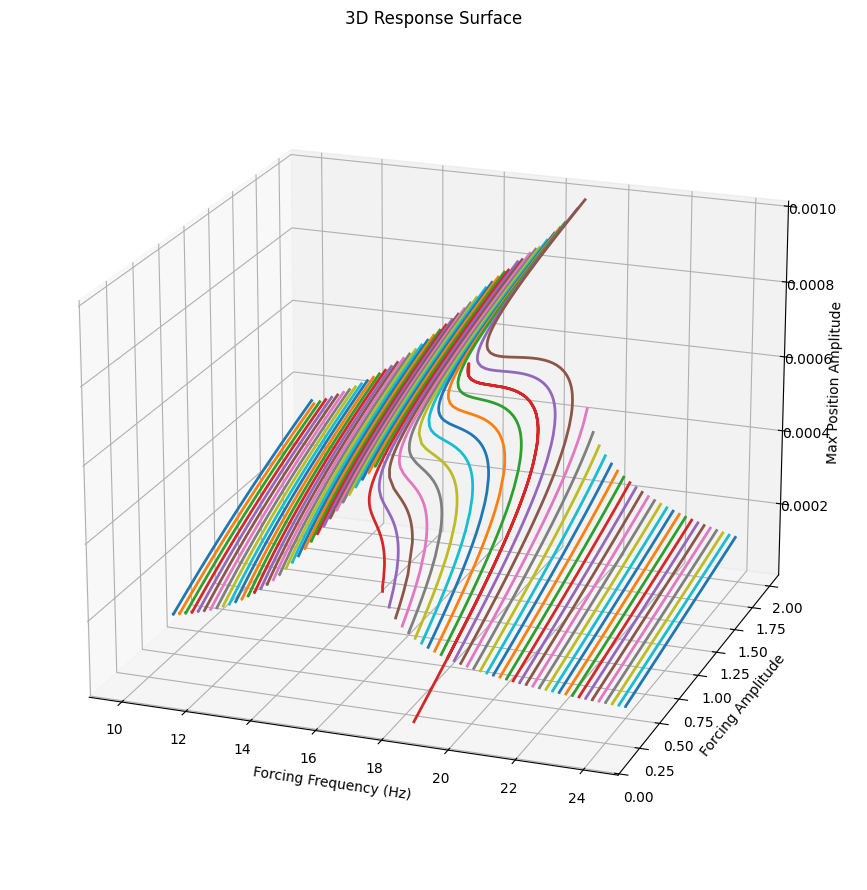

In [5]:
plot_3DS_curves(ml_data)

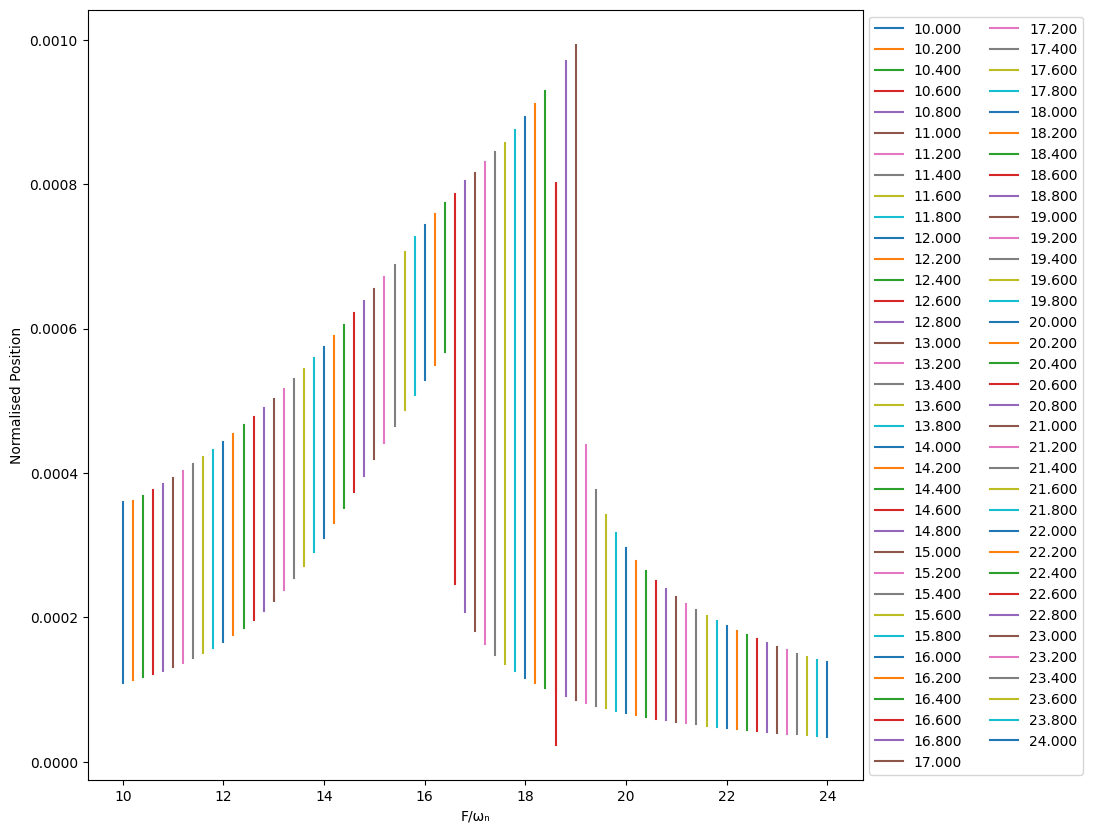

In [6]:
plot_FRC(ml_data)

#### MDOF Beam Definition

In [7]:
# Beam paremeters for 2 mode system
k_nl = 4250000
w_1 = 91.734505484821950
w_2 = 3.066194429903638e02
zeta_1 = 0.03
zeta_2 = 0.09
phi_L = jnp.array([[-7.382136522799137, 7.360826867549465]])

# Modal Matrices
_M = jnp.eye(2)
_C = jnp.array([[2 * zeta_1 * w_1, 0], [0, 2 * zeta_2 * w_2]])
_K = jnp.array([[w_1**2, 0], [0, w_2**2]])

In [8]:
limq11, limq12, limqd11, limqd12 = info["q1min"], info["q1max"], info["qd1max"], info["qd1min"]
limq21, limq22, limqd21, limqd22 = info["q2min"], info["q2max"], info["qd2max"], info["qd2min"]

q1a, q1da = jnp.linspace(limq11, limq12, 100), jnp.linspace(
    limqd11, limqd12, 100)
q1aa, q1daa = jnp.meshgrid(q1a, q1da)

q2a, q2da = jnp.linspace(limq21, limq22, 100), jnp.linspace(
    limqd21, limqd22, 100)
q2aa, q2daa = jnp.meshgrid(q2a, q2da)

q1a.shape, q1da.shape, q1aa.shape, q1daa.shape, q2a.shape, q2da.shape, q2aa.shape, q2daa.shape

((100,),
 (100,),
 (100, 100),
 (100, 100),
 (100,),
 (100,),
 (100, 100),
 (100, 100))

In [9]:
M_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_M, jnp.concatenate([q1daa.reshape(-1, 1), q2daa.reshape(-1, 1)], axis=1)**2)

K_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_K, jnp.concatenate([q1aa.reshape(-1, 1), q2aa.reshape(-1, 1)], axis=1)**2) + 0.25 * k_nl * jax.vmap(jnp.dot, in_axes=(None, 0))(phi_L.T, (jax.vmap(jnp.dot, in_axes=(None, 0))(phi_L, jnp.concatenate([q1aa.reshape(-1, 1), q2aa.reshape(-1, 1)], axis=1)**4)))

C_anal = 0.5 * jax.vmap(jnp.dot, in_axes=(None, 0))(_C, jnp.concatenate([q1daa.reshape(-1, 1), q2daa.reshape(-1, 1)], axis=1)**2)

L_anal = M_anal - K_anal

M_anal.shape, K_anal.shape, C_anal.shape

((10000, 2), (10000, 2), (10000, 2))

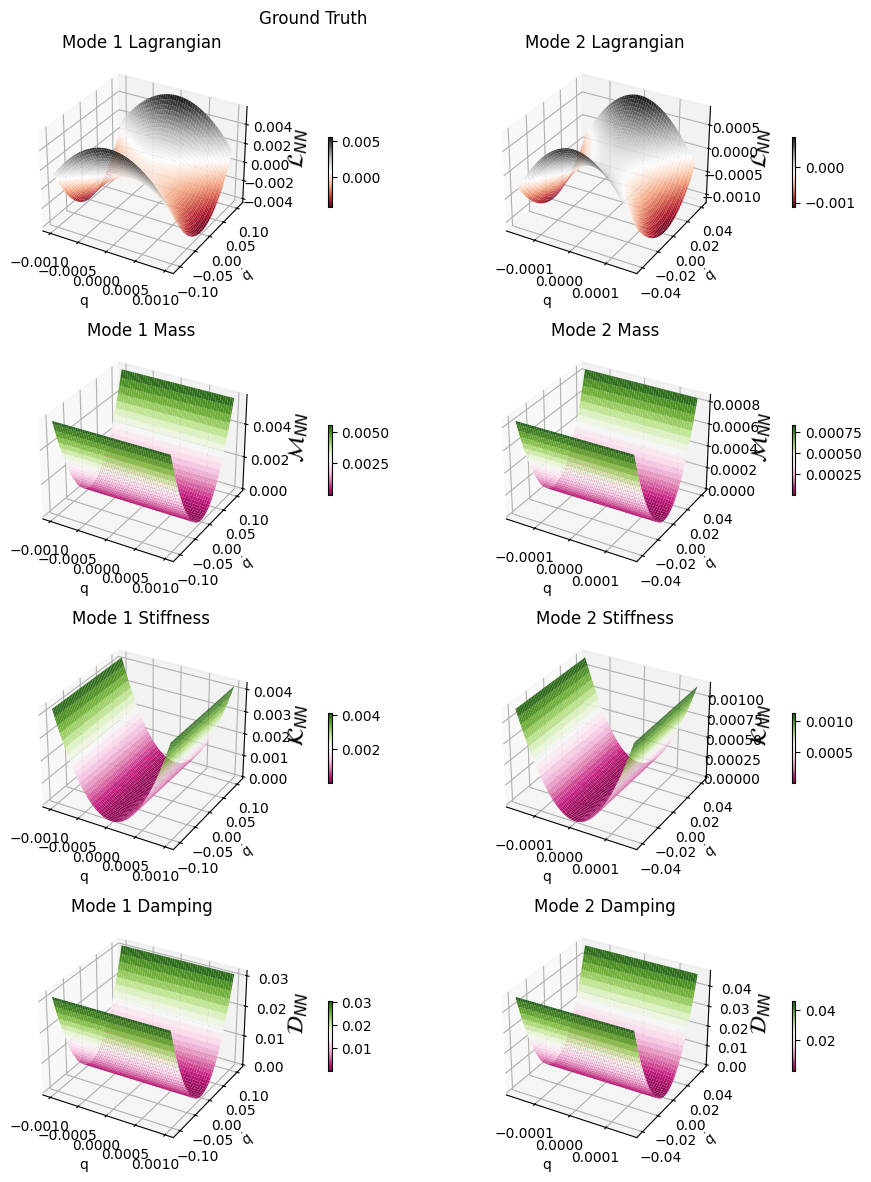

In [10]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Ground Truth")

# --------------------------------- FUNCTIONS

# -------------------------------- Lagrangian
ax = fig.add_subplot(421, projection="3d")
m = ax.plot_surface(q1aa, q1daa, L_anal[:, 0].reshape(q1aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 1 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(422, projection="3d")
m = ax.plot_surface(q2aa, q2daa, L_anal[:, 1].reshape(q2aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 2 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Mass
ax = fig.add_subplot(423, projection="3d")
m = ax.plot_surface(q1aa, q1daa, M_anal[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(424, projection="3d")
m = ax.plot_surface(q2aa, q2daa, M_anal[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Stiffness
ax = fig.add_subplot(425, projection="3d")
m = ax.plot_surface(q1aa, q1daa, K_anal[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(426, projection="3d")
m = ax.plot_surface(q2aa, q2daa, K_anal[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Damping
ax = fig.add_subplot(427, projection="3d")
m = ax.plot_surface(q1aa, q1daa, C_anal[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(428, projection="3d")
m = ax.plot_surface(q2aa, q2daa, C_anal[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
# fig.savefig(f"./Modal_LNN/{file_name}-LD.png")
